###Building SPPMI, SVD, word2vec models

In [0]:
#!pip install pymorphy2

In [8]:
import numpy as np
import gzip
import pickle
import os
import tqdm
import nltk
import pymorphy2
from nltk.corpus import stopwords
from nltk import wordpunct_tokenize
from string import punctuation

nltk.download('stopwords')
nltk.download('punkt')
morph = pymorphy2.MorphAnalyzer()
russian_stopwords = nltk.corpus.stopwords.words('russian')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
def year_category(year):
  if year < 1917:
      cat = 0
  if year < 1990 and year >= 1917:
      cat = 1
  if year < 2020 and year >= 1990:
      cat = 2 

  return cat

def preprocess(text):
  tokens = nltk.sent_tokenize(text.lower())
  tokens = [nltk.word_tokenize(sent) for sent in tokens]
  for i in range(len(tokens)):
    tokens[i] = [token for token in tokens[i] if token.isalpha()]
    tokens[i] = [morph.parse(token)[0].normal_form for token in tokens[i] if morph.parse(token)[0].normal_form not in russian_stopwords and token != " " \
                and token.strip() not in punctuation]
  return tokens

In [0]:
# test
p = "Кирилл работает над проектом. Максим написал код."
preprocess(p)

[['кирилл', 'работать', 'проект'], ['максим', 'написать', 'код']]

In [0]:
directory = "gdrive/My Drive/Colab Notebooks/texts/texts"

vocab = [{} for i in range(3)]
word_counts = [{} for i in range(3)]
thr = 20
inds = [0, 0, 0]
texts = [[], [], []]

count = 0

for root, dirs, files in os.walk(directory, topdown=False):
    for name in tqdm.tqdm_notebook(files):
      # if count == 4:
      #   break;

      if name.endswith(".txt"):
          file_object = open(os.path.join(root, name), encoding='utf-8')
          text = file_object.read()
          year = int(name[:4])
          year_cat = year_category(year)

          tokens = preprocess(text)

          for sent in tokens:
            for token in sent:
              if token in word_counts[year_cat]:
                word_counts[year_cat][token] += 1
              else:
                word_counts[year_cat][token] = 1

              if token not in vocab[year_cat] and word_counts[year_cat][token] >= thr:
                vocab[year_cat][token] = inds[year_cat]
                inds[year_cat] += 1
              
            texts[year_cat].append(sent)
        
      # count += 1

In [0]:
# saving lemmatized texts 
with open("gdrive/My Drive/Colab Notebooks/lemmatized_texts.txt", "wb") as fp:   #Pickling
  pickle.dump(texts, fp)

In [0]:
# loading lemmatized texts 
with open("gdrive/My Drive/Colab Notebooks/lemmatized_texts.txt", "rb") as fp:   # Unpickling
  texts = pickle.load(fp)

In [0]:
# take only words in intersection
keys_from_vocabs = [set(vocab[i].keys()) for i in range(3)]
words_intersection = set.intersection(*keys_from_vocabs)
print('Number of words in intersection:', len(words_intersection))
vocab_filtered={}

for i, word in enumerate(words_intersection):
    vocab_filtered[word] = i

Number of words in intersection: 4992


In [0]:
# saving lemmatized vacabulary and word_counts
# with open("gdrive/My Drive/Colab Notebooks/vocab.txt", "wb") as fp:
#   pickle.dump(vocab, fp)

# with open("gdrive/My Drive/Colab Notebooks/vocab_filtered.txt", "wb") as fp:
#   pickle.dump(vocab_filtered, fp)

# with open("gdrive/My Drive/Colab Notebooks/word_counts.txt", "wb") as fp:
#   pickle.dump(word_counts, fp)

# reading 
with open("gdrive/My Drive/Colab Notebooks/vocab.txt", "rb") as fp:
  vocab = pickle.load(fp)

with open("gdrive/My Drive/Colab Notebooks/vocab_filtered.txt", "rb") as fp:
  vocab_filtered = pickle.load(fp)

with open("gdrive/My Drive/Colab Notebooks/word_counts.txt", "rb") as fp:
  word_counts = pickle.load(fp)

In [0]:
from scipy.sparse import lil_matrix

def create_corpus_matrix(text, vocabulary, L=2):
    vocab_size = len(vocabulary)
    corpus_matrix = lil_matrix((vocab_size,vocab_size))
    
    for sent in text:
        for central_pos, central_word in enumerate(sent):
            if central_word in vocabulary:
                left_pos = max(0, central_pos - L)
                right_pos = min(len(sent), central_pos + L + 1)
                for context_word in sent[left_pos : central_pos] + sent[central_pos + 1 : right_pos + 1]:
                    if context_word in vocabulary:
                        ind_central = vocabulary[central_word]
                        ind_context = vocabulary[context_word]
                        corpus_matrix[ind_central, ind_context] += 1

    return corpus_matrix

In [19]:
cats = [0, 1, 2]
corpus_matrices = []

for cat_id in cats:
  print('Year category is', cat_id)
  print('Vocabulary size is', len(vocab_filtered))
  print('...Creating corpus matrix...')
  corpus_matrices.append(create_corpus_matrix(texts[cat_id], vocab_filtered))
  print('...Corpus matrix created...')

Year category is 0
Vocabulary size is 4992
...Creating corpus matrix...
...Corpus matrix created...
Year category is 1
Vocabulary size is 4992
...Creating corpus matrix...
...Corpus matrix created...
Year category is 2
Vocabulary size is 4992
...Creating corpus matrix...
...Corpus matrix created...


In [21]:
print('Size (number of nonzeros) of corpus matrix (era 0) =', corpus_matrices[0].size)
print('Size (number of nonzeros) of corpus matrix (era 1) =', corpus_matrices[1].size)
print('Size (number of nonzeros) of corpus matrix (era 2) =', corpus_matrices[2].size)

Size (number of nonzeros) of corpus matrix (era 0) = 1375438
Size (number of nonzeros) of corpus matrix (era 1) = 1384884
Size (number of nonzeros) of corpus matrix (era 2) = 1326774


In [0]:
from scipy.sparse.linalg import svds 
from scipy.sparse import csc_matrix, lil_matrix, coo_matrix
from sklearn.metrics.pairwise import cosine_similarity

class WordVectors:

    def __init__(self, vocabulary, corpus_matrix):
        self.vocab = vocabulary
        self.corpus_matrix = corpus_matrix
        self.inv_vocab = {v: k for k, v in self.vocab.items()}

        self.SPPMI = None
        self.embedding_matrix = None    
    
    def compute_SPPMI(self, k=5): 
        """ 
        Takes corpus matrix and returns SPPMI.
        """
        if self.SPPMI != 'scipy.sparse.coo.coo_matrix':
            self.SPPMI = lil_matrix(self.corpus_matrix.shape)
            
        w_counts = np.array(self.corpus_matrix.sum(axis=1).T)[0]
        c_counts = np.array(self.corpus_matrix.sum(axis=0))[0]
        eps = 1e-15
        corpus_matrix_size = self.corpus_matrix.size
        for i, r in enumerate(self.corpus_matrix.rows):
            for j in r:
              self.SPPMI[i,j] = self.corpus_matrix[i,j] * corpus_matrix_size / w_counts[i] / c_counts[j]
              self.SPPMI[i,j] = np.maximum(np.log(self.SPPMI[i,j]) - np.log(k), 0)
                
    def compute_embedding_matrix(self, d=200):
        """ 
        Takes SPPMI and returns embedding matrix.
        """
        
        U, S, V_h = svds(self.SPPMI.tocsc(), k=d)
        self.embedding_matrix = np.dot(U, np.diag(np.sqrt(S)))

    def word_vector(self, word, matrix_type='embedding_matrix'):
        """ 
        Takes word and returns its word vector.
        matrix_type - 'SPPMI' or 'embedding_matrix'
        """
        word_id = self.vocab[word]
        if matrix_type == 'embedding_matrix':
            word_vector = self.embedding_matrix[word_id]
        else:
            word_vector = self.SPPMI[word_id].toarray()[0]

        return word_vector

    def nearest_words(self, word, top_n=10, matrix_type='embedding_matrix'):
        """ 
        Takes word from the vocabulary and returns its top_n
        nearest neighbors in terms of cosine similarity.
        matrix_type - 'SPPMI' or 'embedding_matrix'
        """
        similarities = cosine_similarity(self.embedding_matrix, self.word_vector(word, matrix_type=matrix_type).reshape(1, -1)).T[0]
        neighbors_ids = np.argsort(similarities)[-top_n - 1:-1]
        neighbors = [(self.inv_vocab[value], similarities[value]) for value in neighbors_ids]                
        neighbors.sort(key=lambda x: -x[1])

        return neighbors

    def polysemy_score(self):
        """ 
        Computes polysemy score for each word
        returns vector of polysemy scores
        """
        if type(self.SPPMI) != 'scipy.sparse.lil.lil_matrix':
            ppmi = lil_matrix(self.SPPMI)
        else:
            ppmi = self.SPPMI
        d = np.zeros((ppmi.shape[0]))
        for i, r in enumerate(ppmi.rows):
          if len(r) > 0:
            d[i] = ppmi[r,r].size / len(r) / max(len(r) - 1, 1)
        return d

    def freq_score(self):
        """ 
        Computes frequency score for each word
        returns vector of frequency scores
        """
        v = np.array(self.corpus_matrix.sum(axis=1))
        return v / v.sum()

In [23]:
models = []

for cat_id in cats:
  print("Era ", cat_id)
  model = WordVectors(vocab_filtered, corpus_matrices[cat_id])
  print("...Computing SPPMI...")
  model.compute_SPPMI()
  print("...Computing embedding matrix...")
  model.compute_embedding_matrix()
  models.append(model)

Era  0
...Computing SPPMI...
...Computing embedding matrix...
Era  1
...Computing SPPMI...
...Computing embedding matrix...
Era  2
...Computing SPPMI...
...Computing embedding matrix...


In [25]:
# test NNs
models[0].nearest_words('письмо')

[('прочесть', 0.7128142970228555),
 ('записка', 0.6620408660219648),
 ('написать', 0.5968207791490422),
 ('строка', 0.5456311307944057),
 ('прочитать', 0.5023060225378222),
 ('газета', 0.4834432355449485),
 ('развернуть', 0.4791024577287749),
 ('читать', 0.4740193297077672),
 ('книга', 0.47178902511912163),
 ('стих', 0.4601674469578152)]

In [26]:
# test how NNs change from era to era 
models[0].nearest_words('красный', top_n=5)

[('длинный', 0.41150206086106444),
 ('чёрный', 0.3622319358468562),
 ('повязать', 0.3342950214090064),
 ('лиловый', 0.33271858922836317),
 ('жёлтый', 0.32861030118127954)]

In [27]:
models[1].nearest_words('красный', top_n=5)

[('орден', 0.5157465605286425),
 ('звезда', 0.508415574964753),
 ('зелёный', 0.47770337792565987),
 ('знамя', 0.47127851171518514),
 ('сверкать', 0.4605363421778149)]

In [28]:
models[2].nearest_words('красный', top_n=5)

[('орден', 0.5356492124899475),
 ('звезда', 0.46868444953147975),
 ('наградить', 0.46331571552608736),
 ('белый', 0.4621617740890897),
 ('медаль', 0.43428663577255705)]

In [4]:
from google.colab import files
src = list(files.upload().values())[0]
open('chronovec.py','wb').write(src)
import chronovec

Saving chronovec.py to chronovec.py


In [0]:
%run chronovec.py

In [31]:
# convert models to w2v format
SPPMI_models_w2v = []
embed_matrix_models_w2v = []

for era_id in range(len(models)):
  SPPMI_models_w2v.append(init_w2v_from_ndarray(models[era_id].SPPMI.toarray(), vocab_filtered))
  embed_matrix_models_w2v.append(init_w2v_from_ndarray(models[era_id].embedding_matrix, vocab_filtered))

/content/chronovec.py:23: RuntimeWarning: invalid value encountered in true_divide
  w2v.wv.syn0[w2v.wv.vocab[key].index] = embeddings[value, :] / np.linalg.norm(embeddings[value, :])


In [0]:
# saving models
i = 1
for model in SPPMI_models_w2v:
    model.save("gdrive/My Drive/Colab Notebooks/SPPMI_model_{}.gensim".format(i))
    i += 1

i = 1
for model in embed_matrix_models_w2v:
    model.save("gdrive/My Drive/Colab Notebooks/embed_matrix_model_{}.gensim".format(i))
    i += 1

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [6]:
# reading models
from gensim.models import Word2Vec

SPPMI_models_w2v = []
embed_matrix_models_w2v = []

for i in range(1, 4):
  model = Word2Vec.load("gdrive/My Drive/Colab Notebooks/SPPMI_model_{}.gensim".format(i))
  SPPMI_models_w2v.append(model)

for i in range(1, 4):
  model = Word2Vec.load("gdrive/My Drive/Colab Notebooks/embed_matrix_model_{}.gensim".format(i))
  embed_matrix_models_w2v.append(model)


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [35]:
# test embeddings are the same or not
w2v_word = embed_matrix_models_w2v[0]['отец']
embed_matrix_word = models[0].embedding_matrix[vocab_filtered['отец']]
np.all(w2v_word - embed_matrix_word / np.linalg.norm(embed_matrix_word) < 1e-5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


True

In [36]:
# test norm
np.linalg.norm(embed_matrix_models_w2v[1]['отец'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


1.0

In [37]:
# alignment (need only for embedding matrix)
align_embeddings(embed_matrix_models_w2v)

###Quantifying semantic change

In [8]:
# test NNs for embedding matrix
word_to_test = 'любовь'
print('NNs to:', word_to_test)

for i, model in enumerate(embed_matrix_models_w2v):
  print('Era ', i)
  for word in model.wv.most_similar(word_to_test, topn=5):
      print(word)

NNs to: любовь
Era  0
('страдание', 0.47311145067214966)
('желание', 0.470164030790329)
('счастие', 0.4383038878440857)
('радость', 0.4018094539642334)
('жажда', 0.38444817066192627)
Era  1
('ласка', 0.530789852142334)
('чувство', 0.40901628136634827)
('нежность', 0.40809550881385803)
('материнский', 0.3853374421596527)
('испытывать', 0.3725816607475281)
Era  2
('ненависть', 0.4315508008003235)
('взаимный', 0.4140672981739044)
('нежность', 0.3817942142486572)
('назвать', 0.354656457901001)
('жалость', 0.3498879373073578)


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [7]:
# test NNs for embedding matrix
word_to_test = 'стол'
print('NNs to:', word_to_test)

for i, model in enumerate(embed_matrix_models_w2v):
  print('Era ', i)
  for word in model.wv.most_similar(word_to_test, topn=5):
      print(word)

NNs to: стол
Era  0
('скатерть', 0.6354990601539612)
('самовар', 0.5913369059562683)
('прибор', 0.5723586082458496)
('накрыть', 0.5709231495857239)
('столик', 0.5543613433837891)
Era  1
('накрыть', 0.6350440382957458)
('столик', 0.6250612139701843)
('скатерть', 0.6197365522384644)
('прибор', 0.6067790985107422)
('поднос', 0.5304452180862427)
Era  2
('поднос', 0.6563591361045837)
('расставить', 0.5528883337974548)
('накрыть', 0.5273836851119995)
('скатерть', 0.5166087746620178)
('столик', 0.5076632499694824)


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [40]:
# test NNs for SPPMI matrix
word_to_test = 'человек'
print('NNs to:', word_to_test)

for i, model in enumerate(SPPMI_models_w2v):
  print('Era ', i)
  for word in model.wv.most_similar(word_to_test, topn=5):
      print(word)

NNs to: человек
Era  0
('честный', 0.16771572828292847)
('добрый', 0.16239143908023834)
('драма', 0.16069768369197845)
('недоразумение', 0.1385415494441986)
('благородный', 0.12233338505029678)
Era  1
('понадобиться', 0.24619261920452118)
('честный', 0.16305407881736755)
('сказка', 0.15718235075473785)
('вежливый', 0.153363436460495)
('скотина', 0.14587661623954773)
Era  2
('семья', 0.21305803954601288)
('умный', 0.16515491902828217)
('честный', 0.1498204469680786)
('ничтожество', 0.14869162440299988)
('чистенький', 0.14806316792964935)


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [41]:
# test semantic_displacement
# example when similarity does not change significantly
word_to_test = 'человек'
print('Semantic change from era 0 to era 1, from era 1 to era 2 for word', word_to_test)
print('Embedding matrix model:')
print(semantic_displacement(embed_matrix_models_w2v, word_to_test))
print('SPPMI matrix model:')
print(semantic_displacement(SPPMI_models_w2v, word_to_test))

# example when similarity changes more significantly
word_to_test = 'красный'
print('Semantic change from era 0 to era 1, from era 1 to era 2 for word', word_to_test)
print('Embedding matrix model:')
print(semantic_displacement(embed_matrix_models_w2v, word_to_test))
print('SPPMI matrix model:')
print(semantic_displacement(SPPMI_models_w2v, word_to_test))

Semantic change from era 0 to era 1, from era 1 to era 2 for word человек
Embedding matrix model:
[0.7957125902175903, 0.709306538105011]
SPPMI matrix model:
[0.43859219551086426, 0.5021107494831085]
Semantic change from era 0 to era 1, from era 1 to era 2 for word красный
Embedding matrix model:
[0.6249158680438995, 0.46975547075271606]
SPPMI matrix model:
[0.8129929304122925, 0.5497406721115112]


In [9]:
# example when similarity does not change significantly
word_to_test = 'стол'
print('Semantic change from era 0 to era 1, from era 1 to era 2 for word', word_to_test)
print('Embedding matrix model:')
print(semantic_displacement(embed_matrix_models_w2v, word_to_test))

Semantic change from era 0 to era 1, from era 1 to era 2 for word стол
Embedding matrix model:
[0.998085971805267, 1.0722408518195152]


In [42]:
# test pairwise_similarity_timeseries
word_1 = 'немец'
word_2 = 'англичанин'

print('Embedding matrix model:')
distances, spearman = pairwise_similarity_timeseries(embed_matrix_models_w2v, np.array([1917, 1990, 2019]), word_1, word_2)
print('..distances:', distances)
print('..spearman:', spearman)
print('SPPMI matrix model:')
distances, spearman = pairwise_similarity_timeseries(SPPMI_models_w2v, np.array([1917, 1990, 2019]), word_1, word_2)
print('..distances:', distances)
print('..spearman:', spearman)

Embedding matrix model:
..distances: [0.50254005 0.16887346 0.08839496]
..spearman: SpearmanrResult(correlation=-1.0, pvalue=0.0)
SPPMI matrix model:
..distances: [0.11507123 0.02960631 0.06618526]
..spearman: SpearmanrResult(correlation=-0.5, pvalue=0.6666666666666667)


In [43]:
# test pairwise_similarity_timeseries
word_1 = 'немец'
word_2 = 'бой'

print('Embedding matrix model:')
distances, spearman = pairwise_similarity_timeseries(embed_matrix_models_w2v, np.array([1917, 1990, 2019]), word_1, word_2)
print('..distances:', distances)
print('..spearman:', spearman)
print('SPPMI matrix model:')
distances, spearman = pairwise_similarity_timeseries(SPPMI_models_w2v, np.array([1917, 1990, 2019]), word_1, word_2)
print('..distances:', distances)
print('..spearman:', spearman)

Embedding matrix model:
..distances: [0.0576892 0.3439775 0.2060048]
..spearman: SpearmanrResult(correlation=0.5, pvalue=0.6666666666666667)
SPPMI matrix model:
..distances: [0.02935402 0.14524785 0.06293464]
..spearman: SpearmanrResult(correlation=0.5, pvalue=0.6666666666666667)


In [45]:
# test discover_shifts
word_counts_merged = {}

for word in word_counts[0]:
  if word in vocab_filtered:
    word_counts_merged[word] = word_counts[0][word] + word_counts[2][word]

discover_shifts(embed_matrix_models_w2v[0], embed_matrix_models_w2v[2], 
                word_counts_merged, 80, 2, 2)

[0.85735884308815, 0.9050182178616524, 0.9518523663282394, 0.771353155374527, 0.8981061950325966, 0.9197883456945419, 0.9124766513705254, 0.8636459112167358, 0.9001438245177269, 0.7759086936712265, 0.8134466856718063, 0.864715650677681, 0.7533701509237289, 0.8232992738485336, 0.8359050303697586, 0.8555043488740921, 0.9570473544299603, 0.924730159342289, 0.8192631304264069, 0.8399565815925598, 0.9247570037841797, 0.8582405596971512, 0.8290147036314011, 0.7846129685640335, 0.828082486987114, 0.7492751479148865, 0.7963341623544693, 0.9740576222538948, 0.8489065170288086, 0.7796718925237656, 0.8763719871640205, 0.9223987311124802, 0.834417462348938, 0.8527423143386841, 0.7563665509223938, 0.6846612095832825, 0.9334542155265808, 0.9526393674314022, 0.9890087628737092, 0.9852705104276538, 0.745633602142334, 0.9342427253723145, 0.9406500607728958, 0.929651290178299, 0.9152427986264229, 1.0415276922285557, 0.8176070153713226, 1.0034432255197316, 0.9662344083189964, 1.0960502475500107, 0.912639

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


([('высовываться', 1.1142537668347359), ('проворно', 1.0960502475500107)],
 [[('наполовину', 0.53368079662323), ('пожилой', 0.41330575942993164)],
  [('думать', 0.37923136353492737), ('моргать', 0.32378867268562317)]],
 [[('реж', 0.3725355267524719), ('сбивать', 0.33962851762771606)],
  [('шагнуть', 0.4262109100818634), ('взбежать', 0.4005662202835083)]])

In [80]:
# learn w2v
models_sgns = train_sgns(texts, 200, 20, in_nb=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
# normalize vectors
models_sgns[0].init_sims(replace=True)
models_sgns[1].init_sims(replace=True)
models_sgns[2].init_sims(replace=True)

In [86]:
# test NNs
models_sgns[0].most_similar('мама')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('душенька', 0.8636568784713745),
 ('папочка', 0.8233079314231873),
 ('папа', 0.818537712097168),
 ('голубчик', 0.8096343278884888),
 ('голубушка', 0.8093241453170776),
 ('небось', 0.7912670373916626),
 ('неужто', 0.7885036468505859),
 ('полно', 0.7847568988800049),
 ('послушаться', 0.7734789848327637),
 ('мамочка', 0.7730671167373657)]

In [88]:
# test norm
np.linalg.norm(models_sgns[0]['мама'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


1.0

### Statistical laws of semantic change

Let's consider era 0 compared to era 1 (we will take embeddings only from models 0 and 1).

We expect that 

1) high **frequency words** will have **lower rate of semantic change**;

2) high **polysemy words** will have **higher rate of semantic change**.

In [0]:
from sklearn.linear_model import LinearRegression

def freq_semantic_change_dependency(word_vec_1, embed_model_1, embed_model_2, vocabulary):
  log_freq = np.log(word_vec_1.freq_score())
  inv_vocabulary = {v: k for k, v in vocabulary.items()}
  semantic_change_rate = np.zeros(len(vocabulary))

  for i in range(len(vocabulary)):
    semantic_change_rate[i] = semantic_displacement([embed_model_1, embed_model_2], inv_vocabulary[i])[0]
  return log_freq, semantic_change_rate

def polysemy_semantic_change_dependency(w2v,model1,model2,voc):
  delta_w=np.array([semantic_displacement([model1,model2],w2v.inv_vocab[i]) for i in range(len(voc))])
  log_poly=w2v.polysemy_score()
  idx=[]
  for i in range(len(voc)):
      if log_poly[i]==0:
          idx.append(i)
  delta_w=np.delete(delta_w,idx)
  log_poly=np.log(np.delete(log_poly,idx))
  return log_poly,delta_w

def linear_regression(x, y):
  lr = LinearRegression()
  lr.fit(x, y)
  prediction = lr.predict(x)
  print(lr.coef_)
  return prediction

#### 1. For embedding matrix

In [103]:
log_freq, semantic_change_rate_freq = \
freq_semantic_change_dependency(models[0], embed_matrix_models_w2v[0], embed_matrix_models_w2v[1], vocab_filtered)
prediction_freq = linear_regression(log_freq, semantic_change_rate_freq)

log_poly, semantic_change_rate_poly = \
polysemy_semantic_change_dependency(models[0], embed_matrix_models_w2v[0], embed_matrix_models_w2v[1], vocab_filtered)
prediction_poly = linear_regression(log_poly.reshape(-1, 1), semantic_change_rate_poly)

[-0.03046681]
[0.07471225]


[Text(0, 0.5, 'Rate of semantic change'),
 Text(0.5, 0, 'Log(polysemy)'),
 Text(0.5, 1.0, 'Law of innovation')]

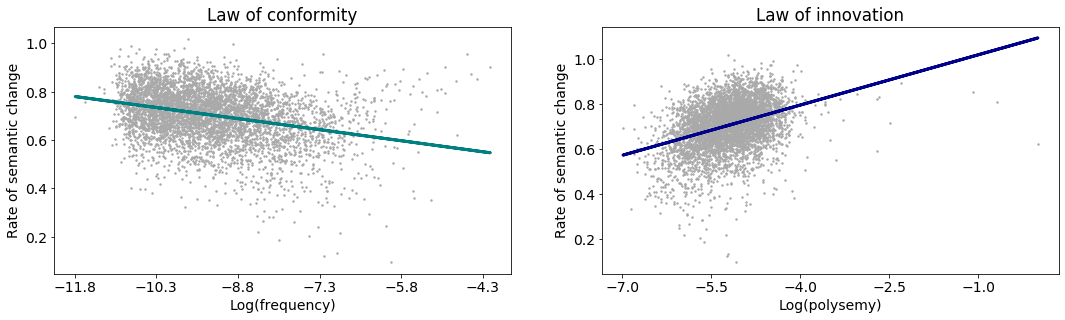

In [106]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 10))

plt.rcParams.update({'font.size': 14})
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.ylabel('Rate of semantic change')

ax1 = plt.subplot(2, 2, 1)
ax1.scatter(log_freq, semantic_change_rate_freq, s=2, c='darkgray')
ax1.plot(log_freq, prediction_freq, c='teal', linewidth=3)
ax1.set(title = 'Law of conformity', xlabel='Log(frequency)', ylabel='Rate of semantic change', 
        xticks=np.around(np.arange(min(log_freq), max(log_freq), step=1.5), decimals=1))

ax2 = plt.subplot(2, 2, 2)
ax2.scatter(log_poly, semantic_change_rate_poly, s=2, c='darkgray')
ax2.plot(log_poly, prediction_poly, c='darkblue', linewidth=3)
ax2.set(title = 'Law of innovation', xlabel='Log(polysemy)', ylabel='Rate of semantic change',
        xticks=np.around(np.arange(min(log_poly), max(log_poly), step=1.5), decimals=1))

#### 2. For SGNS

In [99]:
log_freq, semantic_change_rate_freq = \
freq_semantic_change_dependency(models[0], models_sgns[0], models_sgns[1], vocab_filtered)
prediction_freq = linear_regression(log_freq, semantic_change_rate_freq)

log_poly, semantic_change_rate_poly = \
polysemy_semantic_change_dependency(models[0], models_sgns[0], models_sgns[1], vocab_filtered)
prediction_poly = linear_regression(log_poly.reshape(-1, 1), semantic_change_rate_poly)

[-0.00329393]
[0.02222674]


[Text(0, 0.5, 'Rate of semantic change'),
 Text(0.5, 0, 'Log(polysemy)'),
 Text(0.5, 1.0, 'Law of innovation')]

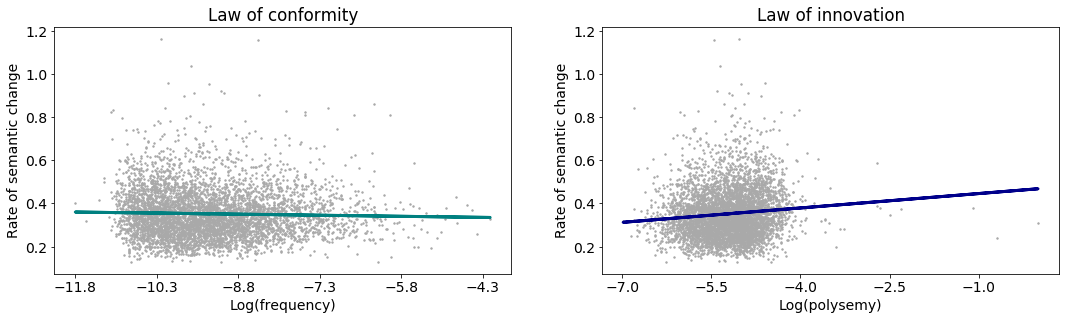

In [100]:
plt.figure(figsize=(18, 10))

plt.rcParams.update({'font.size': 14})
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.ylabel('Rate of semantic change')

ax1 = plt.subplot(2, 2, 1)
ax1.scatter(log_freq, semantic_change_rate_freq, s=2, c='darkgray')
ax1.plot(log_freq, prediction_freq, c='teal', linewidth=3)
ax1.set(title = 'Law of conformity', xlabel='Log(frequency)', ylabel='Rate of semantic change', 
        xticks=np.around(np.arange(min(log_freq), max(log_freq), step=1.5), decimals=1))

ax2 = plt.subplot(2, 2, 2)
ax2.scatter(log_poly, semantic_change_rate_poly, s=2, c='darkgray')
ax2.plot(log_poly, prediction_poly, c='darkblue', linewidth=3)
ax2.set(title = 'Law of innovation', xlabel='Log(polysemy)', ylabel='Rate of semantic change',
        xticks=np.around(np.arange(min(log_poly), max(log_poly), step=1.5), decimals=1))

### Polysemy test



In [0]:
word = 'немец'

print(np.log(models[0].polysemy_score()[vocab_filtered[word]]), 
      np.log(models[1].polysemy_score()[vocab_filtered[word]]),
      np.log(models[2].polysemy_score()[vocab_filtered[word]]))

-5.4031432565604165 -4.787491742782046 -5.7201002259402385
